In [2]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # ================= LOAD IMAGE =================
# img = cv2.imread(
#     r"D:\datashare\runs\detect\runs\predict\crater_preds5\crops\crater\orientation01_light0110.jpg",
#     cv2.IMREAD_GRAYSCALE
# )

# if img is None:
#     raise ValueError("Image not found")

# h, w = img.shape

# # ================= PREPROCESS =================
# blur = cv2.GaussianBlur(img, (7, 7), 0)
# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
# enhanced = clahe.apply(blur)

# edges = cv2.Canny(enhanced, 50, 140)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

# # Remove crop borders
# border = 10
# edges[:border, :] = 0
# edges[-border:, :] = 0
# edges[:, :border] = 0
# edges[:, -border:] = 0

# # ================= RIM ISOLATION =================
# inv = cv2.bitwise_not(edges)
# dist = cv2.distanceTransform(inv, cv2.DIST_L2, 5)
# dist = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)
# rim_mask = (dist < 0.15).astype(np.uint8) * 255

# contours, _ = cv2.findContours(
#     rim_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
# )

# best_cnt = max(contours, key=cv2.contourArea)
# ellipse = cv2.fitEllipse(best_cnt)

# (cx, cy), (W, H), angle = ellipse
# a = max(W, H) / 2.0
# b = min(W, H) / 2.0

# # ================= BOUNDARY-CONSTRAINED ADJUSTMENT =================
# theta = np.deg2rad(angle)
# cos_t, sin_t = np.cos(theta), np.sin(theta)

# def ellipse_points(cx, cy, a, b, angle, n=360):
#     t = np.linspace(0, 2*np.pi, n)
#     x = a * np.cos(t)
#     y = b * np.sin(t)
#     xr = x * cos_t - y * sin_t + cx
#     yr = x * sin_t + y * cos_t + cy
#     return xr, yr

# # Compute maximum scale so ellipse stays inside image
# scale = 1.0
# for _ in range(10):
#     xs, ys = ellipse_points(cx, cy, a * scale, b * scale, angle)
#     if (xs.min() < 0 or ys.min() < 0 or
#         xs.max() >= w or ys.max() >= h):
#         scale *= 0.95
#     else:
#         break

# a *= scale
# b *= scale

# # ================= FINAL DRAW =================
# output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# final_ellipse = ((cx, cy), (2*a, 2*b), angle)

# cv2.ellipse(output, final_ellipse, (0, 255, 0), 2)
# cv2.circle(output, (int(cx), int(cy)), 3, (0, 0, 255), -1)

# # ================= OUTPUT =================
# print("Final Ellipse Parameters (image-safe):")
# print(f"Center (x, y): ({cx:.2f}, {cy:.2f})")
# print(f"Semi-major axis: {a:.2f}")
# print(f"Semi-minor axis: {b:.2f}")
# print(f"Angle (deg): {angle:.2f}")

# plt.figure(figsize=(6, 6))
# plt.imshow(output, cmap="gray")
# plt.axis("off")
# plt.show()


Ellipse Parameters:
Center (x, y): (105.96, 105.88)
Semi-major axis: 113.87
Semi-minor axis: 107.51
Angle (deg): 42.42


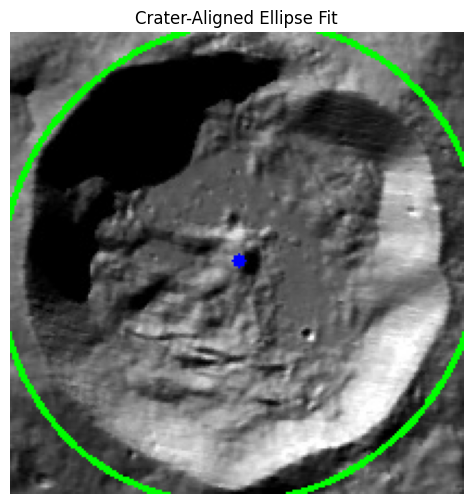

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ================= LOAD IMAGE =================
img = cv2.imread(
    r"D:\datashare\yolo_output\orientation01_light02\crops\crater\orientation01_light02.jpg",
    cv2.IMREAD_GRAYSCALE
)

if img is None:
    raise ValueError("Image not found")

h, w = img.shape

# ================= PREPROCESS =================
blur = cv2.GaussianBlur(img, (7, 7), 0)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(blur)

# ================= EDGE =================
edges = cv2.Canny(enhanced, 50, 140)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

# ================= REMOVE RECTANGLE BORDERS =================
border = 10
edges[:border, :] = 0
edges[-border:, :] = 0
edges[:, :border] = 0
edges[:, -border:] = 0

# ================= DISTANCE TRANSFORM (CRATER RIM BAND) =================
inv = cv2.bitwise_not(edges)
dist = cv2.distanceTransform(inv, cv2.DIST_L2, 5)
dist = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

# Rim candidates = pixels near strong edges
rim_mask = (dist < 0.15).astype(np.uint8) * 255

# ================= CONTOURS =================
contours, _ = cv2.findContours(
    rim_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
)

best_cnt = None
best_area = 0

for cnt in contours:
    if len(cnt) < 40:
        continue

    area = cv2.contourArea(cnt)
    if area > best_area:
        best_area = area
        best_cnt = cnt

# ================= ROBUST ELLIPSE FIT =================
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

if best_cnt is None or len(best_cnt) < 5:
    raise RuntimeError("Crater rim not detected properly")

ellipse = cv2.fitEllipse(best_cnt)

(cx, cy), (W, H), angle = ellipse
major = max(W, H) / 2.0
minor = min(W, H) / 2.0

# ================= DRAW =================
cv2.ellipse(output, ellipse, (0, 255, 0), 2)
cv2.circle(output, (int(cx), int(cy)), 3, (0, 0, 255), -1)

# ================= OUTPUT PARAMETERS =================
print("Ellipse Parameters:")
print(f"Center (x, y): ({cx:.2f}, {cy:.2f})")
print(f"Semi-major axis: {major:.2f}")
print(f"Semi-minor axis: {minor:.2f}")
print(f"Angle (deg): {angle:.2f}")

# ================= SHOW =================
plt.figure(figsize=(6, 6))
plt.imshow(output, cmap="gray")
plt.title("Crater-Aligned Ellipse Fit")
plt.axis("off")
plt.show()



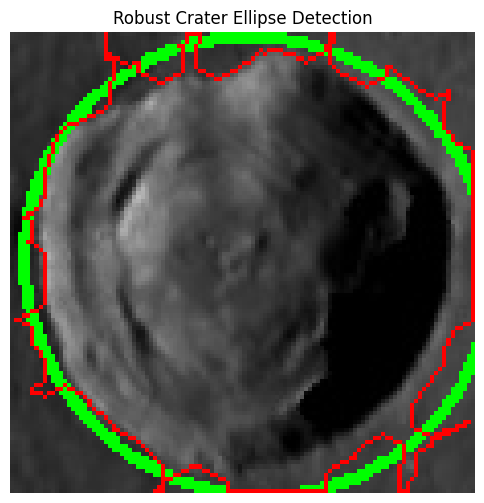

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ================= LOAD IMAGE =================
img = cv2.imread(
    r"D:\datashare\runs\detect\runs\predict\crater_preds5\crops\crater\orientation01_light012.jpg",
    cv2.IMREAD_GRAYSCALE
)

if img is None:
    raise ValueError("Image not found. Check path.")

h, w = img.shape

# ================= PREPROCESSING =================
# Remove noise but keep edges
blur = cv2.GaussianBlur(img, (7, 7), 0)

# Adaptive contrast enhancement (important for lunar shadows)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(blur)

# ================= EDGE DETECTION =================
edges = cv2.Canny(enhanced, 40, 120)

# Close broken crater rims
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

# ================= CONTOUR EXTRACTION =================
contours, _ = cv2.findContours(
    edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE
)

best_contour = None
best_score = 0

# ================= FILTER CONTOURS =================
for cnt in contours:
    if len(cnt) < 30:
        continue

    area = cv2.contourArea(cnt)
    if area < 300:
        continue

    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue

    circularity = 4 * np.pi * area / (perimeter ** 2)

    # Crater rims are roughly circular/elliptical
    if circularity < 0.3:
        continue

    # Prefer large + circular contours
    score = area * circularity
    if score > best_score:
        best_score = score
        best_contour = cnt

# ================= ELLIPSE FITTING =================
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

if best_contour is not None and len(best_contour) >= 5:
    ellipse = cv2.fitEllipse(best_contour)
    cv2.ellipse(output, ellipse, (0, 255, 0), 2)
    cv2.drawContours(output, [best_contour], -1, (255, 0, 0), 1)
else:
    print("No valid crater contour found")

# ================= VISUALIZATION =================
plt.figure(figsize=(6, 6))
plt.imshow(output, cmap="gray")
plt.title("Robust Crater Ellipse Detection")
plt.axis("off")
plt.show()


In [5]:
# Setup: Import libraries and configure paths
import csv
import math
import random
import shutil
from pathlib import Path
import pandas as pd
import numpy as np

# Image dimensions (standard for your crater dataset)
IMG_WIDTH = 1024
IMG_HEIGHT = 1024

# YOLO class ID for cratersimport cv2
import numpy as np

# -------- LOAD --------
img = cv2.imread(
    r"D:\datashare\yolo_output\orientation01_light02\crops\crater\orientation01_light02.jpg",
    cv2.IMREAD_GRAYSCALE
)
h, w = img.shape

# -------- PREPROCESS --------
blur = cv2.GaussianBlur(img, (7, 7), 0)
clahe = cv2.createCLAHE(3.0, (8, 8))
enhanced = clahe.apply(blur)

# -------- EDGE --------
edges = cv2.Canny(enhanced, 50, 140)

# -------- GRADIENT DIRECTION --------
gx = cv2.Sobel(enhanced, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(enhanced, cv2.CV_64F, 0, 1, ksize=3)
grad_angle = np.arctan2(gy, gx)

# -------- REMOVE BORDER EDGES --------
edges[:10, :] = 0
edges[-10:, :] = 0
edges[:, :10] = 0
edges[:, -10:] = 0

# -------- DISTANCE TRANSFORM (RIM BAND) --------
inv = cv2.bitwise_not(edges)
dist = cv2.distanceTransform(inv, cv2.DIST_L2, 5)
dist = cv2.normalize(dist, None, 0, 1, cv2.NORM_MINMAX)

rim_mask = (dist < 0.12).astype(np.uint8)

# -------- RIM POINT COLLECTION --------
ys, xs = np.where(rim_mask > 0)
points = np.column_stack((xs, ys))

# -------- ROBUST ELLIPSE FIT --------
points = points.reshape(-1, 1, 2).astype(np.int32)

ellipse = cv2.fitEllipse(points)

(cx, cy), (W, H), angle = ellipse
a, b = max(W, H) / 2, min(W, H) / 2

# -------- OUTPUT PARAMETERS ONLY --------
print("Ellipse (rim-aligned):")
print(f"Center: ({cx:.1f}, {cy:.1f})")
print(f"Semi-major: {a:.1f}")
print(f"Semi-minor: {b:.1f}")
print(f"Angle: {angle:.1f}")

CLASS_ID = 0

# Configuration
CONFIG = {
    'gt_csv': Path(r'D:\datashare\train-sb\train-gt.csv'),  # Ground truth CSV with ellipse data
    'images_root': Path(r'D:\datashare\train\train'),  # Root folder containing altitude/longitude/images
    'dataset_out': Path(r'D:\datashare\yolo_ellipse_dataset'),  # Output YOLO dataset
    'train_ratio': 0.8,  # 80% train, 20% validation
    'seed': 42,
    'format': 'ellipse'  # 'bbox' for standard YOLO, 'obb' for oriented bbox, 'ellipse' for full ellipse
}

print("Configuration loaded:")
print(f"  GT CSV: {CONFIG['gt_csv']}")
print(f"  Images: {CONFIG['images_root']}")
print(f"  Output: {CONFIG['dataset_out']}")
print(f"  Format: {CONFIG['format']}")


Ellipse (rim-aligned):
Center: (105.4, 107.2)
Semi-major: 97.4
Semi-minor: 93.6
Angle: 163.2
Configuration loaded:
  GT CSV: D:\datashare\train-sb\train-gt.csv
  Images: D:\datashare\train\train
  Output: D:\datashare\yolo_ellipse_dataset
  Format: ellipse


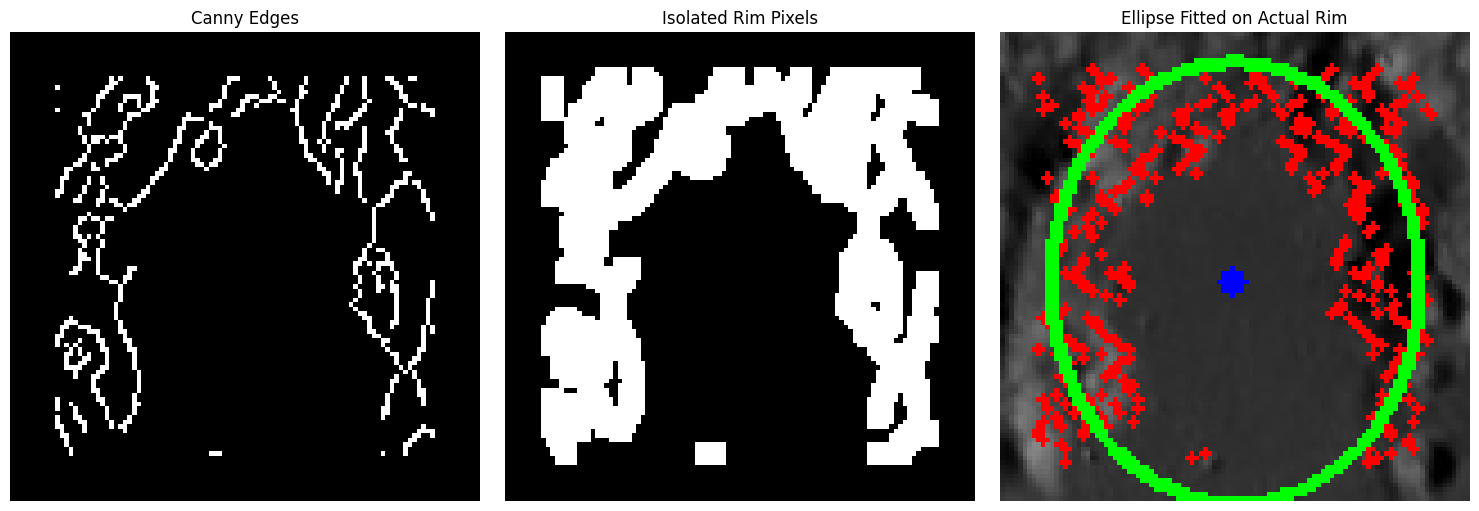

Ellipse parameters (rim-based):
Center (x, y): (51.63, 55.29)
Semi-major axis: 48.87
Semi-minor axis: 40.81
Angle (deg): 178.77


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ================= LOAD IMAGE =================
img = cv2.imread(
    r"D:\datashare\runs\detect\runs\predict\crater_preds5\crops\crater\orientation01_light0124.jpg",
    cv2.IMREAD_GRAYSCALE
)

if img is None:
    raise ValueError("Image not found")

h, w = img.shape

# ================= PREPROCESS =================
blur = cv2.GaussianBlur(img, (7, 7), 0)
clahe = cv2.createCLAHE(3.0, (8, 8))
enhanced = clahe.apply(blur)

# ================= EDGE DETECTION =================
edges = cv2.Canny(enhanced, 50, 140)

# Remove crop borders
edges[:10, :] = 0
edges[-10:, :] = 0
edges[:, :10] = 0
edges[:, -10:] = 0

# ================= DISTANCE TRANSFORM (RIM BAND) =================
inv = cv2.bitwise_not(edges)
dist = cv2.distanceTransform(inv, cv2.DIST_L2, 5)
dist = cv2.normalize(dist, None, 0, 1, cv2.NORM_MINMAX)

# Thin rim band only
rim_mask = (dist < 0.12).astype(np.uint8) * 255

# ================= COLLECT RIM POINTS =================
ys, xs = np.where(rim_mask > 0)
points = np.column_stack((xs, ys))

if len(points) < 30:
    raise RuntimeError("Not enough rim points detected")

points = points.reshape(-1, 1, 2).astype(np.int32)

# ================= ELLIPSE FIT =================
ellipse = cv2.fitEllipse(points)
(cx, cy), (W, H), angle = ellipse
a = max(W, H) / 2.0
b = min(W, H) / 2.0

# ================= VISUAL OUTPUT =================
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw rim points
for p in points[::10]:   # subsample for clarity
    cv2.circle(output, tuple(p[0]), 1, (255, 0, 0), -1)

# Draw ellipse
cv2.ellipse(output, ellipse, (0, 255, 0), 2)

# Draw center
cv2.circle(output, (int(cx), int(cy)), 3, (0, 0, 255), -1)

# ================= SHOW ALL STAGES =================
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edges")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rim_mask, cmap="gray")
plt.title("Isolated Rim Pixels")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(output, cmap="gray")
plt.title("Ellipse Fitted on Actual Rim")
plt.axis("off")

plt.tight_layout()
plt.show()

# ================= PRINT PARAMETERS =================
print("Ellipse parameters (rim-based):")
print(f"Center (x, y): ({cx:.2f}, {cy:.2f})")
print(f"Semi-major axis: {a:.2f}")
print(f"Semi-minor axis: {b:.2f}")
print(f"Angle (deg): {angle:.2f}")


In [ ]:
print("dfd")

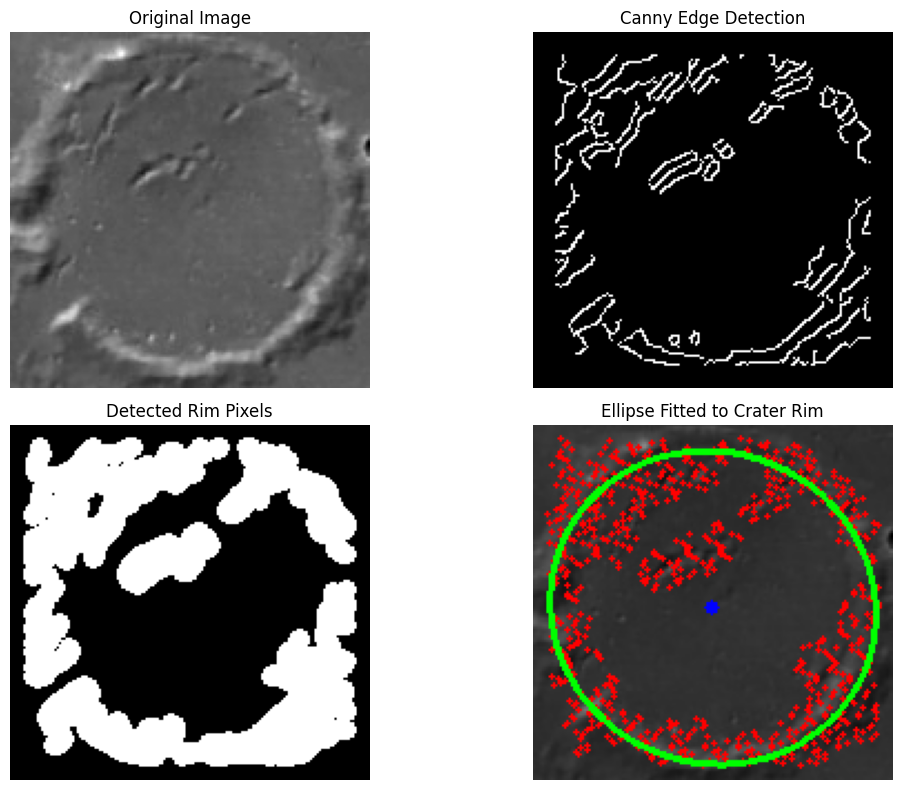

Ellipse parameters (rim-based):
Center (x, y): (80.58, 82.06)
Semi-major axis: 73.92
Semi-minor axis: 69.88
Angle (deg): 113.05


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ================= LOAD IMAGE =================
img = cv2.imread(
    r"D:\datashare\yolo_output\orientation01_light02\crops\crater\orientation01_light022.jpg",
    cv2.IMREAD_GRAYSCALE
)

if img is None:
    raise ValueError("Image not found")

h, w = img.shape

# ================= PREPROCESS =================
blur = cv2.GaussianBlur(img, (7, 7), 0)
clahe = cv2.createCLAHE(3.0, (8, 8))
enhanced = clahe.apply(blur)

# ================= EDGE DETECTION =================
edges = cv2.Canny(enhanced, 50, 140)

# Remove crop borders
edges[:10, :] = 0
edges[-10:, :] = 0
edges[:, :10] = 0
edges[:, -10:] = 0

# ================= DISTANCE TRANSFORM (RIM BAND) =================
inv = cv2.bitwise_not(edges)
dist = cv2.distanceTransform(inv, cv2.DIST_L2, 5)
dist = cv2.normalize(dist, None, 0, 1, cv2.NORM_MINMAX)

rim_mask = (dist < 0.12).astype(np.uint8) * 255

# ================= COLLECT RIM POINTS =================
ys, xs = np.where(rim_mask > 0)
points = np.column_stack((xs, ys))

if len(points) < 30:
    raise RuntimeError("Not enough rim points detected")

points = points.reshape(-1, 1, 2).astype(np.int32)

# ================= ELLIPSE FIT =================
ellipse = cv2.fitEllipse(points)
(cx, cy), (W, H), angle = ellipse
a = max(W, H) / 2.0
b = min(W, H) / 2.0

# ================= FINAL OVERLAY =================
overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for p in points[::15]:
    cv2.circle(overlay, tuple(p[0]), 1, (255, 0, 0), -1)

cv2.ellipse(overlay, ellipse, (0, 255, 0), 2)
cv2.circle(overlay, (int(cx), int(cy)), 3, (0, 0, 255), -1)

# ================= SIMPLE VISUALIZATION =================
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(rim_mask, cmap="gray")
plt.title("Detected Rim Pixels")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(overlay, cmap="gray")
plt.title("Ellipse Fitted to Crater Rim")
plt.axis("off")

plt.tight_layout()
plt.show()

# ================= PRINT PARAMETERS =================
print("Ellipse parameters (rim-based):")
print(f"Center (x, y): ({cx:.2f}, {cy:.2f})")
print(f"Semi-major axis: {a:.2f}")
print(f"Semi-minor axis: {b:.2f}")
print(f"Angle (deg): {angle:.2f}")


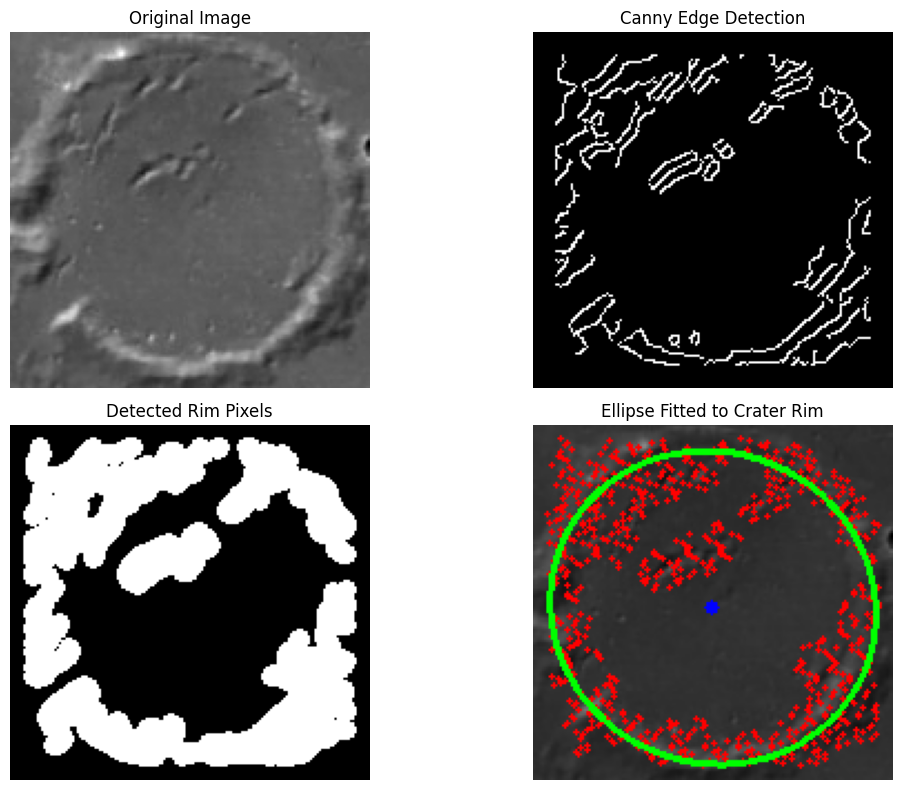

Ellipse parameters (rim-based):
Center (x, y): (80.58, 82.06)
Semi-major axis: 73.92
Semi-minor axis: 69.88
Angle (deg): 113.05


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ================= LOAD IMAGE =================
img = cv2.imread(
    r"D:\datashare\yolo_output\orientation01_light02\crops\crater\orientation01_light022.jpg",
    cv2.IMREAD_GRAYSCALE
)

if img is None:
    raise ValueError("Image not found")

h, w = img.shape

# ================= PREPROCESS =================
blur = cv2.GaussianBlur(img, (7, 7), 0)
clahe = cv2.createCLAHE(3.0, (8, 8))
enhanced = clahe.apply(blur)

# ================= EDGE DETECTION =================
edges = cv2.Canny(enhanced, 50, 140)

# Remove crop borders
edges[:10, :] = 0
edges[-10:, :] = 0
edges[:, :10] = 0
edges[:, -10:] = 0

# ================= DISTANCE TRANSFORM (RIM BAND) =================
inv = cv2.bitwise_not(edges)
dist = cv2.distanceTransform(inv, cv2.DIST_L2, 5)
dist = cv2.normalize(dist, None, 0, 1, cv2.NORM_MINMAX)

rim_mask = (dist < 0.12).astype(np.uint8) * 255

# ================= COLLECT RIM POINTS =================
ys, xs = np.where(rim_mask > 0)
points = np.column_stack((xs, ys))

if len(points) < 30:
    raise RuntimeError("Not enough rim points detected")

points = points.reshape(-1, 1, 2).astype(np.int32)

# ================= ELLIPSE FIT =================
ellipse = cv2.fitEllipse(points)
(cx, cy), (W, H), angle = ellipse
a = max(W, H) / 2.0
b = min(W, H) / 2.0

# ================= FINAL OVERLAY =================
overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for p in points[::15]:
    cv2.circle(overlay, tuple(p[0]), 1, (255, 0, 0), -1)

cv2.ellipse(overlay, ellipse, (0, 255, 0), 2)
cv2.circle(overlay, (int(cx), int(cy)), 3, (0, 0, 255), -1)

# ================= SIMPLE VISUALIZATION =================
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(rim_mask, cmap="gray")
plt.title("Detected Rim Pixels")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(overlay, cmap="gray")
plt.title("Ellipse Fitted to Crater Rim")
plt.axis("off")

plt.tight_layout()
plt.show()

# ================= PRINT PARAMETERS =================
print("Ellipse parameters (rim-based):")
print(f"Center (x, y): ({cx:.2f}, {cy:.2f})")
print(f"Semi-major axis: {a:.2f}")
print(f"Semi-minor axis: {b:.2f}")
print(f"Angle (deg): {angle:.2f}")
